# Imports and Utility Variables

In [2]:
import os
import datetime

import numpy as np
import pandas as pd

import astropy.units as u
from astropy.timeseries import TimeSeries
from astropy.table import Table, vstack, MaskedColumn, unique
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

ITURBIDE_DATA_FILE_PATH = "/home/ramon/uanl/thesis/Backup Data/Iturbide/ATOJ339.9469+45.1464_SPM.dat"
GAIA_EPOCH_PHOTOMETRY_CSV_PATH = "/home/ramon/uanl/thesis/Backup Data/Gaia Epoch Photometry - Indiv/DR3/rel-norm-flux.ecsv"
ZTF_G_DATA_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/rel-zg-flux.ecsv"
ZTF_R_DATA_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/rel-zr-flux.ecsv"

ITURBIDE_OUTPUT_PATH = "/home/ramon/uanl/thesis/Backup Data/Iturbide/cleaned-iturbide.ecsv"
CLEANED_ZTF_OUTPUT_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/cleaned-ztf-flux.ecsv"

In [3]:
objCoord = SkyCoord.from_name("ATO J339.9469+45.1464")
objCoord

<SkyCoord (ICRS): (ra, dec) in deg
    (339.94690379, 45.14639753)>

In [4]:
iturbideLocation = EarthLocation(lon=-99.895328*u.deg, lat=24.75521 * u.deg, height=2400*u.m)
iturbideLocation

<EarthLocation (-996310.5451336, -5711351.68420869, 2655479.91503921) m>

In [5]:
ztfPalomarLocation = EarthLocation.of_site("Palomar")
ztfPalomarLocation

<EarthLocation (-2410346.78217658, -4758666.82504051, 3487942.97502457) m>

# Load Data

## Iturbide

In [7]:
allIturbideObj: Table = Table.read(ITURBIDE_DATA_FILE_PATH, format='ascii')
allIturbideObj.rename_columns(['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', ],
                              ['fname', 'filter', 'exptime', 'jd', 'airmass', 
								'mag1', 'mag2', 'mag3', 'mag4', 'mag5', 'mag6', 'mag7', 
								'err1', 'err2', 'err3', 'err4', 'err5', 'err6', 'err7'])
# allIturbideObjDf.columns = ['fname', 'filter', 'exptime', 'hjd', 'airmass', 
# 					  'mag1', 'mag2', 'mag3', 'mag4', 'mag5', 'mag6', 'mag7', 
# 					  'err1', 'err2', 'err3', 'err4', 'err5', 'err6', 'err7']
# allIturbideObjDf = allIturbideObjDf[(allIturbideObjDf['err1'] < 1) & (allIturbideObjDf['err5'] < 90)] # removing most egregious data points
allIturbideObj = allIturbideObj[(allIturbideObj['err1'] < 1) & (allIturbideObj['err5'] < 90)] # removing most egregious data points
allIturbideObj

fname,filter,exptime,jd,airmass,mag1,mag2,mag3,mag4,mag5,mag6,mag7,err1,err2,err3,err4,err5,err6,err7
str11,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
s_0001o.fit,W,60.0,2459874.66590992,1.076,19.5253,16.7627,18.4668,17.891,18.3033,18.3373,17.7953,0.019,0.003,0.009,0.006,0.008,0.008,0.006
s_0002o.fit,W,60.0,2459874.66661048,1.077,19.4874,16.7586,18.4767,17.8835,18.2984,18.3346,17.7884,0.016,0.003,0.008,0.006,0.007,0.007,0.005
s_0003o.fit,W,60.0,2459874.6673093,1.077,19.5269,16.7615,18.4741,17.8885,18.2952,18.3356,17.787,0.015,0.003,0.008,0.006,0.007,0.007,0.005
s_0004o.fit,W,60.0,2459874.6680094,1.078,19.4836,16.7533,18.4543,17.8807,18.3064,18.3241,17.7936,0.016,0.003,0.008,0.006,0.007,0.007,0.006
s_0005o.fit,W,60.0,2459874.66870811,1.078,19.4708,16.7678,18.4633,17.8942,18.3105,18.3356,17.8094,0.015,0.003,0.008,0.006,0.007,0.007,0.006
s_0006o.fit,W,60.0,2459874.66940867,1.079,19.5117,16.764,18.4672,17.9005,18.3097,18.3558,17.8048,0.016,0.003,0.008,0.006,0.007,0.008,0.006
s_0007o.fit,W,60.0,2459874.67010726,1.08,19.5037,16.7631,18.4628,17.8958,18.307,18.3515,17.7923,0.015,0.003,0.008,0.006,0.007,0.007,0.005
s_0008o.fit,W,60.0,2459874.67080979,1.08,19.5084,16.7739,18.4832,17.9084,18.3217,18.3647,17.7984,0.018,0.003,0.008,0.006,0.008,0.008,0.006
s_0009o.fit,W,60.0,2459874.67150849,1.081,19.531,16.7768,18.4746,17.9109,18.3229,18.3627,17.7937,0.017,0.003,0.008,0.006,0.008,0.008,0.006


In [9]:
COMP_ID = 5
# atoDiffMag = pd.DataFrame(columns=['hjd', 'mag', 'err', 'filter'])
atoDiffMag = Table()
atoDiffMag['jd'] = Time(allIturbideObj['jd'], scale='utc', format='jd')
atoDiffMag['mag'] = allIturbideObj['mag1'] - allIturbideObj[f'mag{COMP_ID}']
atoDiffMag['err'] = np.sqrt(np.power(allIturbideObj['err1'], 2) + np.power(allIturbideObj[f'err{COMP_ID}'], 2))
atoDiffMag['filter'] = 'Iturbide:Luminance'
atoDiffMag

jd,mag,err,filter
Time,float64,float64,str18
2459874.66590992,1.2220000000000013,0.0206155281280883,Iturbide:Luminance
2459874.66661048,1.189,0.01746424919657298,Iturbide:Luminance
2459874.6673093,1.2317,0.016552945357246846,Iturbide:Luminance
2459874.6680094,1.1771999999999991,0.01746424919657298,Iturbide:Luminance
2459874.66870811,1.1602999999999994,0.016552945357246846,Iturbide:Luminance
2459874.66940867,1.2020000000000017,0.01746424919657298,Iturbide:Luminance
2459874.67010726,1.1966999999999999,0.016552945357246846,Iturbide:Luminance
2459874.67080979,1.1867000000000019,0.01969771560359221,Iturbide:Luminance
2459874.67150849,1.2080999999999982,0.018788294228055936,Iturbide:Luminance


In [11]:
iturbideObsTime = atoDiffMag['jd']
ltt = iturbideObsTime.light_travel_time(skycoord=objCoord, kind='heliocentric', location=iturbideLocation)
atoDiffMag['hjd'] = iturbideObsTime + ltt
atoDiffMag.remove_column('jd')
atoDiffMag['ltt_corr'] = ltt
atoDiffMag

mag,err,filter,hjd,ltt_corr
float64,float64,str18,Time,TimeDelta
1.2220000000000013,0.0206155281280883,Iturbide:Luminance,2459874.6694241795,0.003514259439162757
1.189,0.01746424919657298,Iturbide:Luminance,2459874.6701247203,0.003514240281085119
1.2317,0.016552945357246846,Iturbide:Luminance,2459874.670823521,0.003514221167058355
1.1771999999999991,0.01746424919657298,Iturbide:Luminance,2459874.6715236017,0.0035142020145036233
1.1602999999999994,0.016552945357246846,Iturbide:Luminance,2459874.672222293,0.003514182896444417
1.2020000000000017,0.01746424919657298,Iturbide:Luminance,2459874.672922834,0.0035141637242508575
1.1966999999999999,0.016552945357246846,Iturbide:Luminance,2459874.6736214045,0.003514144602463344
1.1867000000000019,0.01969771560359221,Iturbide:Luminance,2459874.6743239155,0.0035141253692836947
1.2080999999999982,0.018788294228055936,Iturbide:Luminance,2459874.6750225965,0.003514106237446774


In [10]:
%%script echo "skip; only using HJD"

# convert hjd -> bjd
# iturbideHjdTime = Time(atoDiffMag['hjd'], scale='utc', format='jd')
iturbideHjdTime = atoDiffMag['hjd']
heliocentricCorrection = iturbideHjdTime.light_travel_time(skycoord=objCoord, kind='heliocentric', location=iturbideLocation)
barycentricCorrection = iturbideHjdTime.light_travel_time(skycoord=objCoord, kind='barycentric', location=iturbideLocation)

iturbideBjdTime = (iturbideHjdTime - heliocentricCorrection) + barycentricCorrection

# using TCB scale to be compatible with Gaia
atoDiffMag['bjd'] = iturbideBjdTime.tcb.value
atoDiffMag

skip; only using HJD


In [12]:
# def hjd_to_observation_date(hjd: Time) -> str:
#     return hjd.strftime(r"%Y-%m-%d")
# atoDiffMag['obsv_date'] = atoDiffMag['hjd'].apply(hjd_to_observation_date)
atoDiffMag['obsv_date'] = [t.strftime(r"%Y-%m-%d") for t in atoDiffMag['hjd']]
atoDiffMag

mag,err,filter,hjd,ltt_corr,obsv_date
float64,float64,str18,Time,TimeDelta,str10
1.2220000000000013,0.0206155281280883,Iturbide:Luminance,2459874.6694241795,0.003514259439162757,2022-10-22
1.189,0.01746424919657298,Iturbide:Luminance,2459874.6701247203,0.003514240281085119,2022-10-22
1.2317,0.016552945357246846,Iturbide:Luminance,2459874.670823521,0.003514221167058355,2022-10-22
1.1771999999999991,0.01746424919657298,Iturbide:Luminance,2459874.6715236017,0.0035142020145036233,2022-10-22
1.1602999999999994,0.016552945357246846,Iturbide:Luminance,2459874.672222293,0.003514182896444417,2022-10-22
1.2020000000000017,0.01746424919657298,Iturbide:Luminance,2459874.672922834,0.0035141637242508575,2022-10-22
1.1966999999999999,0.016552945357246846,Iturbide:Luminance,2459874.6736214045,0.003514144602463344,2022-10-22
1.1867000000000019,0.01969771560359221,Iturbide:Luminance,2459874.6743239155,0.0035141253692836947,2022-10-22
1.2080999999999982,0.018788294228055936,Iturbide:Luminance,2459874.6750225965,0.003514106237446774,2022-10-22


## Gaia

In [9]:
%%script echo "skipping; will no longer be using Gaia data"
gaiaDataDf = Table.read(GAIA_EPOCH_PHOTOMETRY_CSV_PATH).to_pandas()
gaiaDataDf['filter'] = gaiaDataDf['band'].map(lambda p: f"Gaia:{p}")
gaiaDataDf['bjd'] = gaiaDataDf['time'].map(lambda t: t + 2455197.5) # tcb, barycentric
gaiaDataDf.index += atoDiffMag.index[-1] + 1
gaiaDataDf

skipping; will no longer be using Gaia data


## ZTF

In [13]:
# ztfDataDf = pd.concat([Table.read(ZTF_G_DATA_PATH).to_pandas(), Table.read(ZTF_R_DATA_PATH).to_pandas()])
# ztfData['band'] = ztfDataDf['filtercode'].map(lambda f: 'ZTF:g' if f == 'zg' else 'ZTF:r')
ztfData = vstack([Table.read(ZTF_G_DATA_PATH), Table.read(ZTF_R_DATA_PATH)])
ztfData['band'] = ['ZTF:g' if f == 'zg' else 'ZTF:r' for f in ztfData['filtercode']]

# ztfDataDf.rename(columns={'magerr': 'err'}, inplace=True)
ztfData.rename_column('magerr', 'err')

# light travel time correction
# ztfHjdTime = Time(ztfDataDf['hjd'], scale='utc', format='jd')
# heliocentricCorrection = ztfHjdTime.light_travel_time(skycoord=objCoord, kind='heliocentric', location=ztfPalomarLocation)
# barycentricCorrection = ztfHjdTime.light_travel_time(skycoord=objCoord, kind='barycentric', location=ztfPalomarLocation)

# ztfBjdTime = (ztfHjdTime - heliocentricCorrection) + barycentricCorrection
# ztfDataDf['bjd'] = ztfBjdTime.tcb

# ztfDataDf.index += gaiaDataDf.index[-1] + 1
# ztfDataDf.index += atoDiffMag.index[-1] + 1
ztfData

oid,expid,hjd,mjd,mag,err,catflags,filtercode,ra,dec,chi,sharp,filefracday,field,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid,flux,fluxerr,band
,,d,d,mag,mag,,,deg,deg,,,,,,,mag,mag,mag,,,s,,,,,
int64,int64,float64,float64,float64,float64,int64,str2,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,str5
771103200012081,47448814,2458228.984821069,58228.4881481,17.5840454,0.0197342671,0,zg,339.9469627,45.1464159,0.361000001,-0.00300000003,20180420488067,771,3,2,20.3199997,26.1658897,0.0215688683,-0.0297699906,1.12665039e-05,30.0,1.80200005,1,0.8512466974342429,0.015472201830924948,ZTF:g
771103200012081,48044724,2458234.944095733,58234.4472454,17.4334183,0.018555779,0,zg,339.9469408,45.1463974,0.931999981,-0.05999999866,20180426447199,771,3,2,19.5400009,25.6539249,0.0282153077,-0.0344086438,1.91989966e-05,30.0,2.12599993,1,0.9779266466675216,0.016713259311285526,ZTF:g
771103200012081,48050421,2458235.001065248,58234.504213,17.4940319,0.0190106239,0,zg,339.9469111,45.1464201,0.649999976,-0.05999999866,20180426504178,771,3,2,20.0400009,26.1324596,0.0191307608,-0.0412657112,8.85321879e-06,30.0,1.51199996,1,0.9248277233109335,0.016193207837325533,ZTF:g
771103200012081,49846564,2458252.963232793,58252.4656481,17.5891399,0.0197770167,0,zg,339.9469224,45.1464253,1.279999971,0.04199999943,20180514465637,771,3,2,21.1599998,26.2559261,0.0154842595,-0.0813824013,5.97686767e-06,30.0,1.44099998,1,0.8472618271845778,0.015433133050246517,ZTF:g
771103200012081,50142988,2458255.9276150335,58255.4298843,17.3031044,0.0176594257,0,zg,339.9469268,45.1464214,0.59799999,-0.01799999923,20180517429873,771,3,2,21.1000004,26.2028542,0.0149421003,-0.0593302026,5.42393491e-06,30.0,1.64900005,1,1.102635168074796,0.017934286191701274,ZTF:g
771103200012081,50747070,2458261.9687530138,58261.470706,17.5298138,0.0192911923,0,zg,339.946875,45.1464203,1.470000029,0.00400000019,20180523470671,771,3,2,21.2000008,26.2077541,0.0167469457,-0.0233822055,6.80576795e-06,30.0,1.28400004,1,0.8948455443904189,0.01589947668686186,ZTF:g
771103200012081,51547567,2458269.974170587,58269.4756713,17.5743046,0.0196530558,0,zg,339.9469458,45.1464186,1.210000038,-0.06700000167,20180531475637,771,3,2,19.7299995,26.2844353,0.0199463703,-0.0297663994,9.64130231e-06,30.0,1.18499994,1,0.858918110413046,0.015547391233341628,ZTF:g
771103200012081,51842940,2458272.928083962,58272.4294097,17.3208179,0.0177750532,0,zg,339.9469204,45.1464128,0.474999994,0.01300000027,20180603429387,771,3,2,20.6200008,26.2381649,0.015438539,-0.0462764166,5.9277836e-06,30.0,1.33700001,1,1.0847919156995953,0.017759593838713103,ZTF:g


## All data

In [14]:
atoDiffMag

mag,err,filter,hjd,ltt_corr,obsv_date
float64,float64,str18,Time,TimeDelta,str10
1.2220000000000013,0.0206155281280883,Iturbide:Luminance,2459874.6694241795,0.003514259439162757,2022-10-22
1.189,0.01746424919657298,Iturbide:Luminance,2459874.6701247203,0.003514240281085119,2022-10-22
1.2317,0.016552945357246846,Iturbide:Luminance,2459874.670823521,0.003514221167058355,2022-10-22
1.1771999999999991,0.01746424919657298,Iturbide:Luminance,2459874.6715236017,0.0035142020145036233,2022-10-22
1.1602999999999994,0.016552945357246846,Iturbide:Luminance,2459874.672222293,0.003514182896444417,2022-10-22
1.2020000000000017,0.01746424919657298,Iturbide:Luminance,2459874.672922834,0.0035141637242508575,2022-10-22
1.1966999999999999,0.016552945357246846,Iturbide:Luminance,2459874.6736214045,0.003514144602463344,2022-10-22
1.1867000000000019,0.01969771560359221,Iturbide:Luminance,2459874.6743239155,0.0035141253692836947,2022-10-22
1.2080999999999982,0.018788294228055936,Iturbide:Luminance,2459874.6750225965,0.003514106237446774,2022-10-22


In [15]:
ztfMagConcat = ztfData.copy()
ztfMagConcat.rename_column('filtercode', 'filter')
ztfMagConcat.remove_columns([c for c in ztfMagConcat.columns if c not in ['hjd', 'mag', 'err', 'filter']])
ztfMagConcat['hjd'] = Time(ztfMagConcat['hjd'], format='jd', scale='utc')
ztfMagConcat['filter'] = ['ZTF:g' if f == 'zg' else 'ZTF:r' for f in ztfMagConcat['filter']]

ztfMagConcat

hjd,mag,err,filter
,mag,mag,
Time,float64,float64,str5
2458228.984821069,17.5840454,0.0197342671,ZTF:g
2458234.944095733,17.4334183,0.018555779,ZTF:g
2458235.001065248,17.4940319,0.0190106239,ZTF:g
2458252.963232793,17.5891399,0.0197770167,ZTF:g
2458255.9276150335,17.3031044,0.0176594257,ZTF:g
2458261.9687530138,17.5298138,0.0192911923,ZTF:g
2458269.974170587,17.5743046,0.0196530558,ZTF:g
2458272.928083962,17.3208179,0.0177750532,ZTF:g


In [17]:
# allDataDf = pd.DataFrame()
# allDataDf['bjd'] = pd.concat([atoDiffMag['bjd'], gaiaDataDf['bjd'], ztfDataDf['bjd']])
# allDataDf['band'] = pd.concat([atoDiffMag['filter'], gaiaDataDf['filter'], ztfDataDf['band']])
# allDataDf['bjd'] = pd.concat([atoDiffMag['bjd'], ztfDataDf['bjd']])
# allDataDf['hjd'] = pd.concat([atoDiffMag['hjd'], ztfDataDf['hjd']])
# allDataDf['band'] = pd.concat([atoDiffMag['filter'], ztfDataDf['band']])

allData = vstack([atoDiffMag, ztfMagConcat])
# allData.remove_column('bjd')

# for LS multiband periodogram
iturbideMask = [f != 'Iturbide:Luminance' for f in allData['filter']]
zgMask = [f != 'ZTF:g' for f in allData['filter']]
zrMask = [f != 'ZTF:r' for f in allData['filter']]
allData['iturbide_mag'] = MaskedColumn(allData['mag'], mask=iturbideMask)
allData['zg_mag'] = MaskedColumn(allData['mag'], mask=zgMask)
allData['zr_mag'] = MaskedColumn(allData['mag'], mask=zrMask)

allData['iturbide_err'] = MaskedColumn(allData['err'], mask=iturbideMask)
allData['zg_err'] = MaskedColumn(allData['err'], mask=zgMask)
allData['zr_err'] = MaskedColumn(allData['err'], mask=zrMask)

# allDataDf['iturbide_mag'] = atoDiffMag['mag']
# allDataDf['iturbide_err'] = atoDiffMag['err']
# allDataDf['obsv_date'] = atoDiffMag['obsv_date']

# gaiaBands = {
#     'Gaia:G': 'g',
#     'Gaia:RP': 'r',
#     'Gaia:BP': 'b'
# }

# for band, code in gaiaBands.items():
#     bandData = gaiaDataDf[gaiaDataDf['filter'] == band]
#     fluxColName = f"gaia_{code}_flux"
#     errColName = f"gaia_{code}_err"
#     allDataDf[fluxColName] = bandData['flux']
#     allDataDf[errColName] = bandData['flux_error']

# allDataDf['ztf_g_mag'] = ztfDataDf[ztfDataDf['filtercode'] == 'zg']['mag']
# allDataDf['ztf_g_err'] = ztfDataDf[ztfDataDf['filtercode'] == 'zg']['err']

# allDataDf['ztf_r_mag'] = ztfDataDf[ztfDataDf['filtercode'] == 'zr']['mag']
# allDataDf['ztf_r_err'] = ztfDataDf[ztfDataDf['filtercode'] == 'zr']['err']

# allDataDf.set_index(pd.DatetimeIndex(pd.to_datetime(allDataDf['bjd'], unit='D', origin='julian')), inplace=True)
# allDataDf.set_index(pd.DatetimeIndex(pd.to_datetime(allDataDf['hjd'], unit='D', origin='julian')), inplace=True)
allData

mag,err,filter,hjd,ltt_corr,obsv_date,iturbide_mag,zg_mag,zr_mag,iturbide_err,zg_err,zr_err
mag,mag,,,,,mag,mag,mag,mag,mag,mag
float64,float64,str18,Time,TimeDelta,str10,float64,float64,float64,float64,float64,float64
1.2220000000000013,0.0206155281280883,Iturbide:Luminance,2459874.6694241795,0.003514259439162757,2022-10-22,1.2220000000000013,--,--,0.0206155281280883,--,--
1.189,0.01746424919657298,Iturbide:Luminance,2459874.6701247203,0.003514240281085119,2022-10-22,1.189,--,--,0.01746424919657298,--,--
1.2317,0.016552945357246846,Iturbide:Luminance,2459874.670823521,0.003514221167058355,2022-10-22,1.2317,--,--,0.016552945357246846,--,--
1.1771999999999991,0.01746424919657298,Iturbide:Luminance,2459874.6715236017,0.0035142020145036233,2022-10-22,1.1771999999999991,--,--,0.01746424919657298,--,--
1.1602999999999994,0.016552945357246846,Iturbide:Luminance,2459874.672222293,0.003514182896444417,2022-10-22,1.1602999999999994,--,--,0.016552945357246846,--,--
1.2020000000000017,0.01746424919657298,Iturbide:Luminance,2459874.672922834,0.0035141637242508575,2022-10-22,1.2020000000000017,--,--,0.01746424919657298,--,--
1.1966999999999999,0.016552945357246846,Iturbide:Luminance,2459874.6736214045,0.003514144602463344,2022-10-22,1.1966999999999999,--,--,0.016552945357246846,--,--
1.1867000000000019,0.01969771560359221,Iturbide:Luminance,2459874.6743239155,0.0035141253692836947,2022-10-22,1.1867000000000019,--,--,0.01969771560359221,--,--


In [18]:
# observationsTs = TimeSeries(time=Time(allDataDf['bjd'], format='jd', scale='tcb'), 
#             data={'signal': allDataDf['signal']*u.mag, 'err': allDataDf['signal_err']*u.mag, 
#                   'bjd': allDataDf['bjd'],
#                   'band': allDataDf['band']})
# observationsTs = TimeSeries.from_pandas(allDataDf, time_scale='tcb')
# observationsTs = TimeSeries.from_pandas(allDataDf)
observationsTs = TimeSeries(allData, time=allData['hjd'])
observationsTs

time,mag,err,filter,hjd,ltt_corr,obsv_date,iturbide_mag,zg_mag,zr_mag,iturbide_err,zg_err,zr_err
,mag,mag,,,,,mag,mag,mag,mag,mag,mag
Time,float64,float64,str18,Time,TimeDelta,str10,float64,float64,float64,float64,float64,float64
2459874.6694241795,1.2220000000000013,0.0206155281280883,Iturbide:Luminance,2459874.6694241795,0.003514259439162757,2022-10-22,1.2220000000000013,———,———,0.0206155281280883,———,———
2459874.6701247203,1.189,0.01746424919657298,Iturbide:Luminance,2459874.6701247203,0.003514240281085119,2022-10-22,1.189,———,———,0.01746424919657298,———,———
2459874.670823521,1.2317,0.016552945357246846,Iturbide:Luminance,2459874.670823521,0.003514221167058355,2022-10-22,1.2317,———,———,0.016552945357246846,———,———
2459874.6715236017,1.1771999999999991,0.01746424919657298,Iturbide:Luminance,2459874.6715236017,0.0035142020145036233,2022-10-22,1.1771999999999991,———,———,0.01746424919657298,———,———
2459874.672222293,1.1602999999999994,0.016552945357246846,Iturbide:Luminance,2459874.672222293,0.003514182896444417,2022-10-22,1.1602999999999994,———,———,0.016552945357246846,———,———
2459874.672922834,1.2020000000000017,0.01746424919657298,Iturbide:Luminance,2459874.672922834,0.0035141637242508575,2022-10-22,1.2020000000000017,———,———,0.01746424919657298,———,———
2459874.6736214045,1.1966999999999999,0.016552945357246846,Iturbide:Luminance,2459874.6736214045,0.003514144602463344,2022-10-22,1.1966999999999999,———,———,0.016552945357246846,———,———
2459874.6743239155,1.1867000000000019,0.01969771560359221,Iturbide:Luminance,2459874.6743239155,0.0035141253692836947,2022-10-22,1.1867000000000019,———,———,0.01969771560359221,———,———


# Lomb-Scargle Periodogram

Manually calculating Iturbide period using Astropy Lomb-Scargle periodogram.

In [13]:
%%script echo "skipping; no longer using Gaia data"
gaiaFluxCols = [c for c in allDataDf.columns if 'gaia' in c and 'flux' in c]
gaiaErrCols = [c for c in allDataDf.columns if 'gaia' in c and 'err' in c]
gaiaBands = ['Gaia:G', 'Gaia:RP', 'Gaia:BP']
gaiaFluxCols, gaiaErrCols, gaiaBands

skipping; no longer using Gaia data


In [19]:
# ztfMagCols = [c for c in allDataDf.columns if 'ztf' in c and 'mag' in c]
# ztfErrCols = [c for c in allDataDf.columns if 'ztf' in c and 'err' in c]

ztfMagCols = ['zg_mag', 'zr_mag']
ztfErrCols = ['zg_err', 'zr_err']
ztfBands = ['ZTF:g', 'ZTF:r']
ztfMagCols, ztfErrCols, ztfBands

(['zg_mag', 'zr_mag'], ['zg_err', 'zr_err'], ['ZTF:g', 'ZTF:r'])

In [20]:
import astropy.units as u
from astropy.timeseries import LombScargleMultiband

# MIN_FREQ = 0.0001 * (1/u.day)
MAX_FREQ = 12 * (1/u.day) # 2 hour period

# model = LombScargleMultiband.from_timeseries(observationsTs, 
#                                              signal_column=['iturbide_mag'] + gaiaFluxCols + ztfMagCols,
#                                              uncertainty_column=['iturbide_err'] + gaiaErrCols + ztfErrCols,
#                                              band_labels=['Iturbide:Luminance'] + gaiaBands + ztfBands)
model = LombScargleMultiband.from_timeseries(observationsTs, 
                                             signal_column=['iturbide_mag'] + ztfMagCols,
                                             uncertainty_column=['iturbide_err'] + ztfErrCols,
                                             band_labels=['Iturbide:Luminance'] + ztfBands)

freqs, power = model.autopower(normalization='psd', maximum_frequency=MAX_FREQ)
bestFreq = freqs[np.argmax(power)]
bestPeriod: u.Unit = 2.0 / bestFreq

Periodo: 8.005473815740778 h (0.33356140898919906 d)
Frecuencia: 2.9979487226364987 1 / d


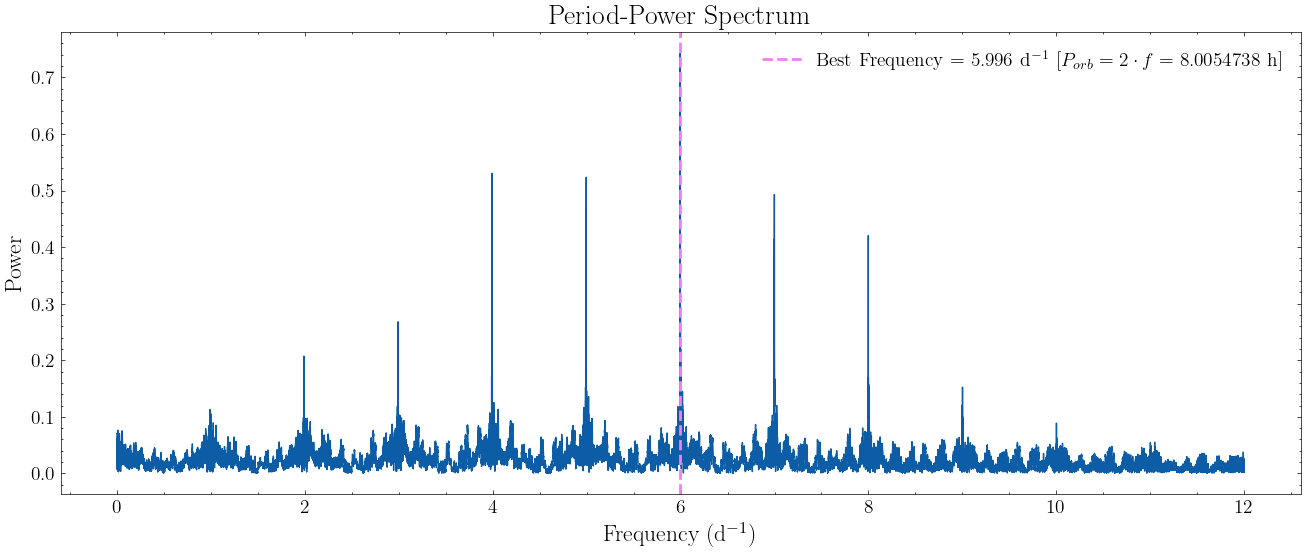

In [21]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
ax.plot(freqs, power)
ax.axvline(bestFreq.value, color='violet', linestyle='--', label=f"Best Frequency = {bestFreq.value:0.3f} d$^{{-1}}$ [$P_{{orb}} = 2 \\cdot f = $ {bestPeriod.to(u.hour)._repr_latex_()}]", linewidth=2, alpha=1)

ax.set_title("Period-Power Spectrum", fontsize=20)
ax.set_xlabel(r"Frequency ($\mathrm{d}^{-1}$)", fontsize=17)
ax.set_ylabel("Power", fontsize=17)
ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14)
print(f"Periodo: {bestPeriod.to(u.hour)} ({bestPeriod})")
print(f"Frecuencia: {1.0 / bestPeriod}")

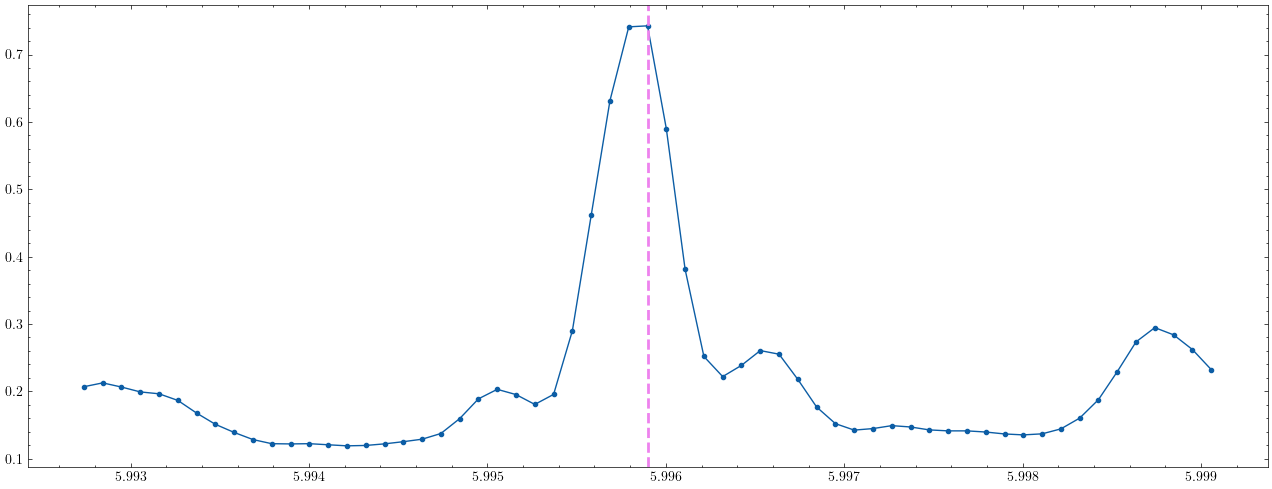

In [22]:
WINDOW_SIZE = 30

peakIdx = np.argmax(power)
freqWindow = freqs[peakIdx-WINDOW_SIZE:peakIdx+WINDOW_SIZE+1]
powerWindow = power[peakIdx-WINDOW_SIZE:peakIdx+WINDOW_SIZE+1]

plt.figure(figsize=(16, 6))
plt.plot(freqWindow, powerWindow, marker='.')
plt.axvline(freqs[peakIdx].value, color='violet', linestyle='--', label=f"Best Frequency = {bestFreq.value:0.3f} day$^{{-1}}$ [P={bestPeriod.to(u.hour):0.3f}]", linewidth=2, alpha=1)

Std: 5.542685847126361e-06 d (0.00013302446033103266 h)
Model period: 0.3335669516750462 d h | LS period: 0.33356140898919906 d


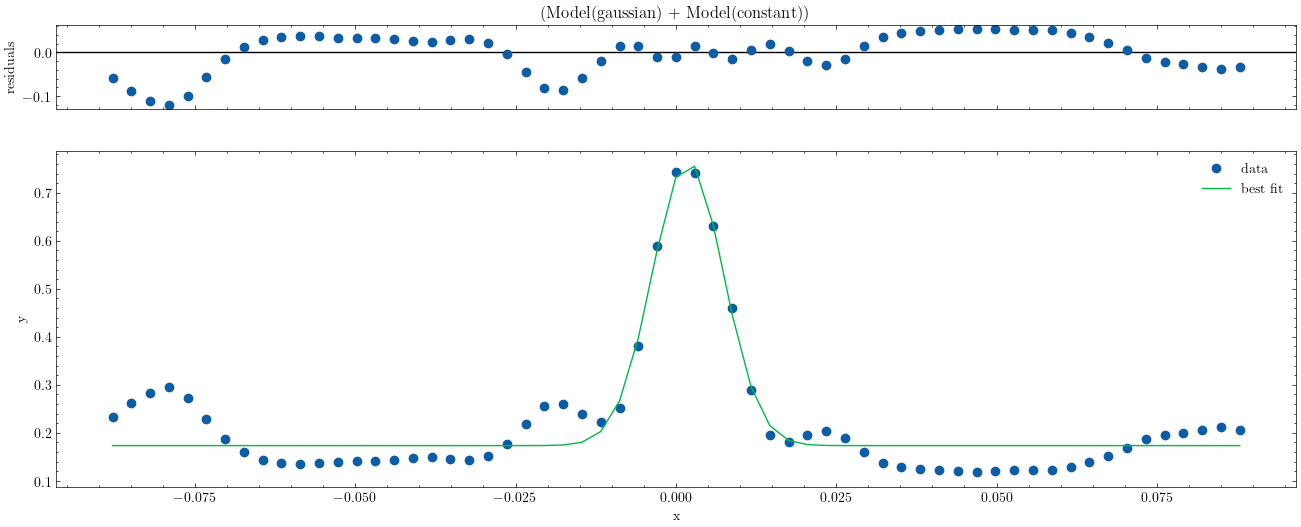

In [26]:
# adjusting Gaussian to determine uncertainties
from lmfit.models import GaussianModel, ConstantModel
from lmfit.model import ModelResult

SCALE_FACTOR = 1000

model = GaussianModel() + ConstantModel()

periodWindow = 1/freqWindow
normalizedPeriodWindow = (periodWindow - np.median(periodWindow)) * SCALE_FACTOR
fitResult: ModelResult = model.fit(powerWindow, x=normalizedPeriodWindow)

fitResult.plot(fig_kws=dict(figsize=(16, 6)))
fitSigma = (fitResult.best_values['sigma']/SCALE_FACTOR) * (u.day)
maxDisplacedPeriod = (2/freqs[peakIdx]) + fitSigma
print(f"Std: {(maxDisplacedPeriod - bestPeriod)} ({(maxDisplacedPeriod - bestPeriod).to(u.hour)})")
print(f"Model period: {maxDisplacedPeriod*u.hour} | LS period: {bestPeriod}")
fitResult

## ZTF data only (SAME PERIOD OBTAINED)

In [27]:
ztfModel = LombScargleMultiband.from_timeseries(observationsTs, 
                                             signal_column=ztfMagCols,
                                             uncertainty_column=ztfErrCols,
                                             band_labels=ztfBands)

ztfFreqs, ztfPower = ztfModel.autopower(normalization='psd', maximum_frequency=MAX_FREQ)
bestFreq_ztf = ztfFreqs[np.argmax(ztfPower)]
bestPeriod_ztf: u.Unit = 2.0 / bestFreq_ztf

(ZTF) Periodo: 8.005473815740778 h (0.33356140898919906 d)
(ZTF) Frecuencia: 2.9979487226364987 1 / d


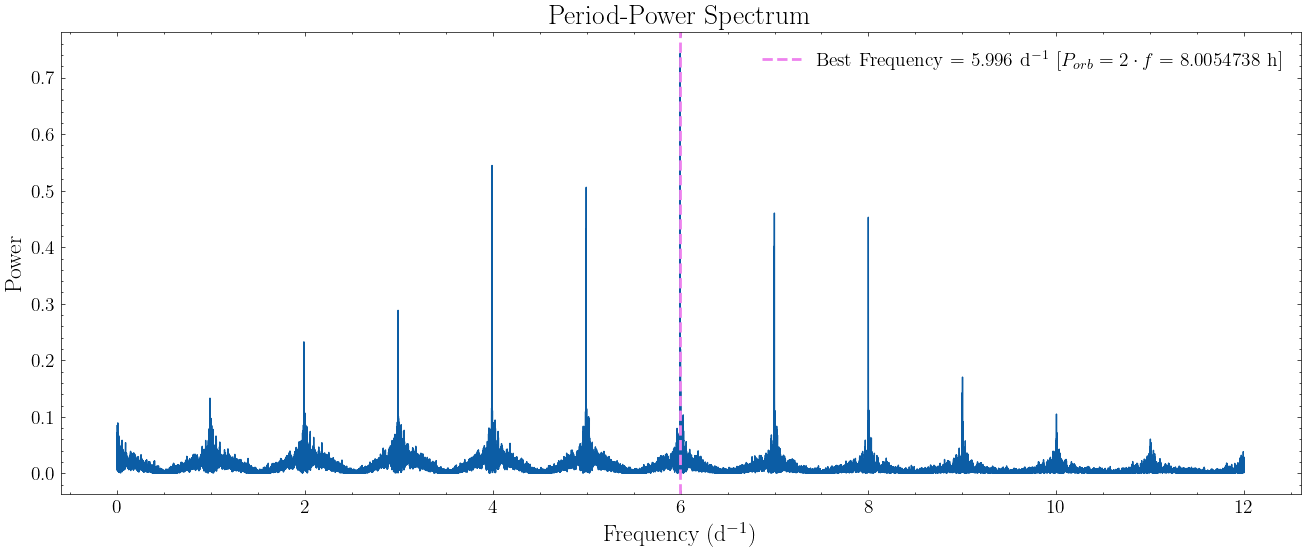

In [28]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
ax.plot(ztfFreqs, ztfPower)
ax.axvline(bestFreq_ztf.value, color='violet', linestyle='--', label=f"Best Frequency = {bestFreq_ztf.value:0.3f} d$^{{-1}}$ [$P_{{orb}} = 2 \\cdot f = $ {bestPeriod_ztf.to(u.hour)._repr_latex_()}]", linewidth=2, alpha=1)

ax.set_title("Period-Power Spectrum", fontsize=20)
ax.set_xlabel(r"Frequency ($\mathrm{d}^{-1}$)", fontsize=17)
ax.set_ylabel("Power", fontsize=17)
ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14)
print(f"(ZTF) Periodo: {bestPeriod_ztf.to(u.hour)} ({bestPeriod_ztf})")
print(f"(ZTF) Frecuencia: {1.0 / bestPeriod_ztf}")

# Period change ($O - C$)

In [180]:
%%script echo "skipping; can't use ZTF data, probably need to pull TESS if available"
from seismolab.OC import OCFitter

# will only use ZTF:r due to highest density and large time coverage
ocTs = observationsTs.copy()
ocTs.remove_rows([i for i, m in enumerate(ocTs['zg_mag'].mask & ocTs['zr_mag'].mask) if m])

plt.scatter(ocTs.time.value, ocTs['mag'], marker='.', s=0.08)
plt.show()

fitter = OCFitter(ocTs.time.value, ocTs['mag'], ocTs['err'], bestPeriod.value)
mintimes, mintimes_err = fitter.fit_minima(showfirst=True)
midtimes, oc, oc_err = fitter.calculate_OC(showplot=True)

skipping; can't use ZTF data, probably need to pull TESS if available


# Phase Plot

Adopted period: 0.3335669516750462 d (8.005606840201109 h)


/tmp/ipykernel_175429/185660987.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


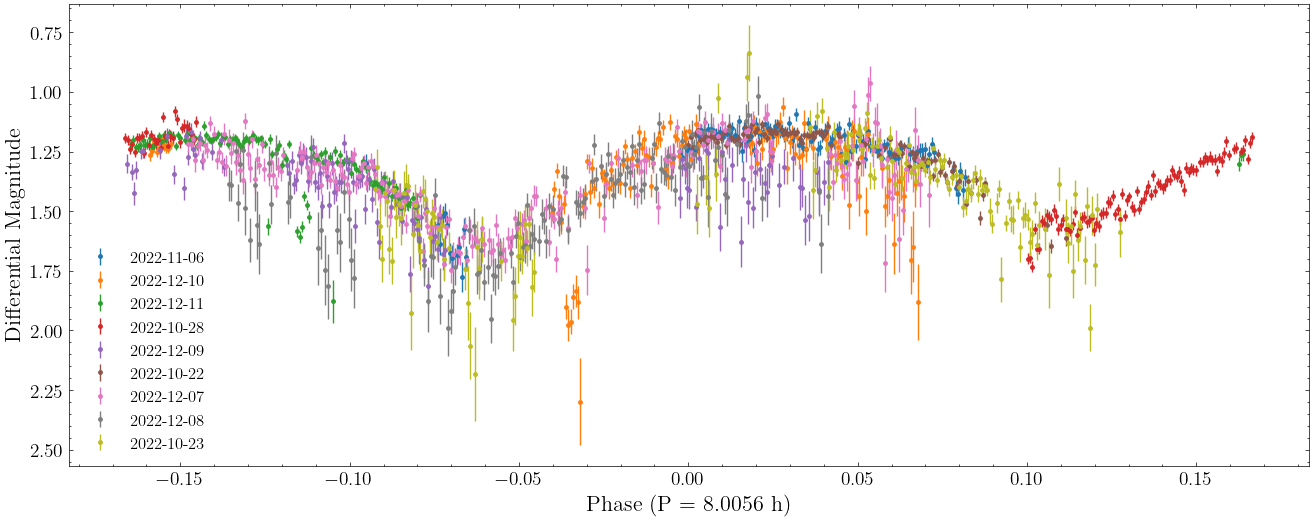

In [35]:
from matplotlib import cm

# period = bestPeriod
period = maxDisplacedPeriod
print(f"Adopted period: {period} ({period.to(u.hour)})")
foldedTs = observationsTs.fold(period=period)

# tsObsvDates = atoDiffMag['obsv_date'].unique()
tsObsvDates = {d for d in atoDiffMag['obsv_date']}

cmap = cm.get_cmap('tab10')
dateColors = [cmap(c) for c in np.linspace(0.001, 1, len(tsObsvDates), endpoint=False)]

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
for obsvDate, color in zip(tsObsvDates, dateColors):
    obsvPoints = foldedTs[foldedTs['obsv_date'] == obsvDate]
    ax.errorbar(obsvPoints.time.value, obsvPoints['iturbide_mag'].unmasked, obsvPoints['iturbide_err'].unmasked, fmt='.', color=color, markersize=5, label=obsvDate)
ax.legend(fontsize=12)

ax.set_xlabel(f"Phase (P = {period.value * 24:.4f} h)", fontsize=16)
ax.set_ylabel("Differential Magnitude", fontsize=16)

ax.tick_params(labelsize=14)
ax.invert_yaxis()

Text(0, 0.5, 'Magnitude')

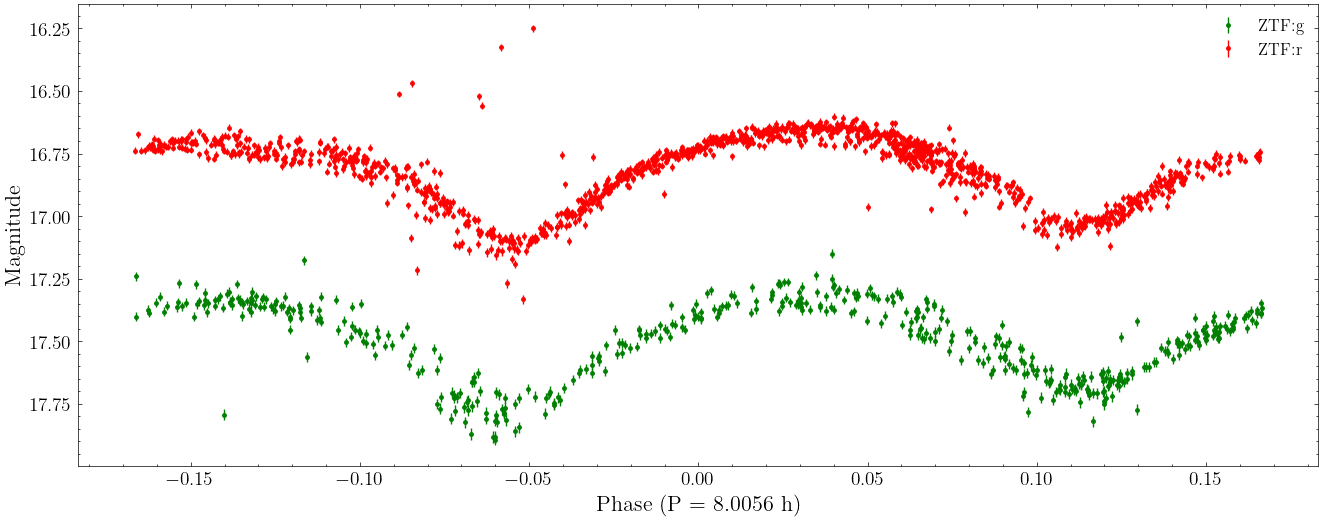

In [37]:
# gaia plot
# gaiaColors = {
#     "Gaia:G": 'g',
#     "Gaia:RP": 'r',
#     "Gaia:BP": 'b'
# }
# plt.figure(figsize=(16, 6))
# for band, fluxCol, errCol in zip(gaiaBands, gaiaFluxCols, gaiaErrCols):
#     bandData = foldedTs[foldedTs['band'] == band]
#     plt.errorbar(bandData.time, bandData[fluxCol], bandData[errCol], marker='.', linestyle='none', c=gaiaColors[band], label=band, markersize=5)
# plt.legend(fontsize=12)
# plt.gca().tick_params(axis='both', labelsize=14)
# plt.ylabel(r"Flux $(\mathrm{e}^{-} \ \mathrm{s}^{-1})$", fontsize=16)
# plt.xlabel(f"Phase (P = {period.value * 24:.2f} h)", fontsize=16)

ztfColors = {
    "ZTF:g": 'g',
    "ZTF:r": 'r'
}
plt.figure(figsize=(16, 6))
for band, fluxCol, errCol in zip(ztfBands, ztfMagCols, ztfErrCols):
    bandData = foldedTs[foldedTs['filter'] == band]
    plt.errorbar(bandData.time.value, bandData[fluxCol].unmasked, bandData[errCol].unmasked, marker='.', linestyle='none', c=ztfColors[band], label=band, markersize=5)
plt.legend(fontsize=12)
plt.gca().tick_params(axis='both', labelsize=14)
plt.gca().invert_yaxis()
plt.xlabel(f"Phase (P = {period.value * 24:.4f} h)", fontsize=16)
plt.ylabel("Magnitude", fontsize=16)

# Data clean

Applying windowed median filter to eliminate worst observations.

In [38]:
from scipy.ndimage import median_filter

def median_filter_mask(vals: np.ndarray, xi_low: float, xi_high: float, filter_size: int, boundary_val: float = None) -> tuple[np.ndarray, np.ndarray, float]:
    """
    Returns the filter mask, baseline calculated from the median filter, and the sigma calculated
    """
    sigma = np.std(vals)
    baseline = median_filter(vals, size=filter_size, mode='constant', cval=(np.median(vals) if not boundary_val else boundary_val))

    fltrLow = (vals - baseline > (-xi_low)*sigma)
    fltrHigh = (vals - baseline < xi_high*sigma) 
    return fltrLow & fltrHigh, baseline, sigma

In [39]:
foldedTs.sort('time')
foldedTs

time,mag,err,filter,hjd,ltt_corr,obsv_date,iturbide_mag,zg_mag,zr_mag,iturbide_err,zg_err,zr_err
,mag,mag,,,,,mag,mag,mag,mag,mag,mag
TimeDelta,float64,float64,str18,Time,TimeDelta,str10,float64,float64,float64,float64,float64,float64
-0.16656279414241248,16.7394791,0.0143604875,ZTF:r,2458760.722809742,--,--,———,———,16.7394791,———,———,0.0143604875
-0.16628667249855297,1.1924000000000028,0.0206155281280883,Iturbide:Luminance,2459880.8409095886,0.0033265785694365207,2022-10-28,1.1924000000000028,———,———,0.0206155281280883,———,———
-0.16627046349418356,17.4029655,0.0183366165,ZTF:g,2459855.823404422,--,--,———,17.4029655,———,———,0.0183366165,———
-0.16614341318476378,17.2404938,0.017265521,ZTF:g,2459894.8508648183,--,--,———,17.2404938,———,———,0.017265521,———
-0.16574905335077222,1.3013000000000012,0.03956008088970497,Iturbide:Luminance,2459922.5373161673,0.0012063471745832476,2022-12-09,1.3013000000000012,———,———,0.03956008088970497,———,———
-0.16558787687158358,1.2027999999999999,0.0206155281280883,Iturbide:Luminance,2459880.841608384,0.0033265544398984777,2022-10-28,1.2027999999999999,———,———,0.0206155281280883,———,———
-0.16550752589167672,16.67313,0.0140637932,ZTF:r,2459206.7028794,--,--,———,———,16.67313,———,———,0.0140637932
-0.16488526109244056,1.2391000000000005,0.0206155281280883,Iturbide:Luminance,2459880.842311,0.003326530177332098,2022-10-28,1.2391000000000005,———,———,0.0206155281280883,———,———


## ZTF

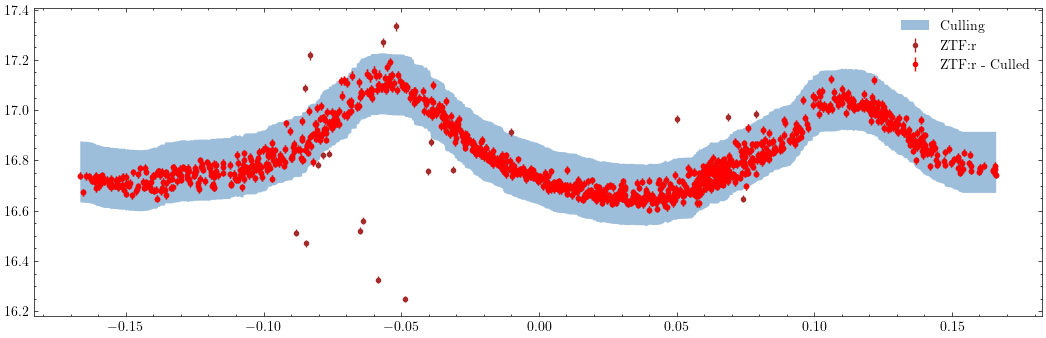

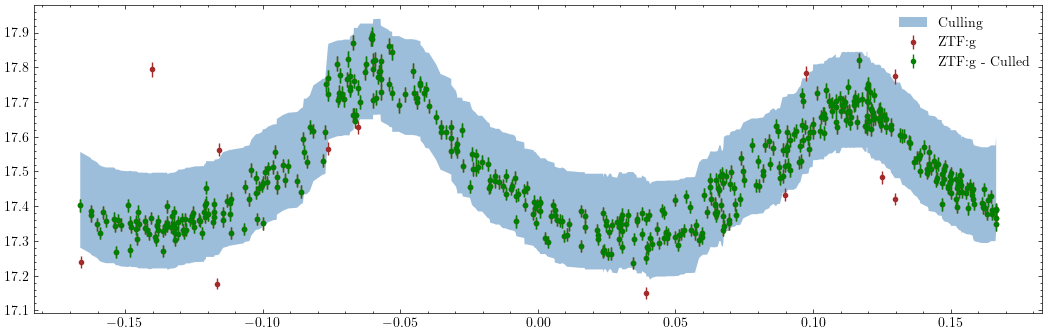

time,mag,err,filter,hjd,ltt_corr,obsv_date,iturbide_mag,zg_mag,zr_mag,iturbide_err,zg_err,zr_err
,mag,mag,,,,,mag,mag,mag,mag,mag,mag
TimeDelta,float64,float64,str18,Time,TimeDelta,str10,float64,float64,float64,float64,float64,float64
-0.16656279414241248,16.7394791,0.0143604875,ZTF:r,2458760.722809742,--,--,———,———,16.7394791,———,———,0.0143604875
-0.16550752589167672,16.67313,0.0140637932,ZTF:r,2459206.7028794,--,--,———,———,16.67313,———,———,0.0140637932
-0.1645700924439879,16.7380829,0.0143540557,ZTF:r,2459206.7038168334,--,--,———,———,16.7380829,———,———,0.0143540557
-0.16353882828233685,16.7365494,0.0143469963,ZTF:r,2458754.721628578,--,--,———,———,16.7365494,———,———,0.0143469963
-0.16269566122438628,16.7252235,0.0142951952,ZTF:r,2458759.72597602,--,--,———,———,16.7252235,———,———,0.0142951952
-0.16238245672808677,16.7186584,0.0142654087,ZTF:r,2458737.710870414,--,--,———,———,16.7186584,———,———,0.0142654087
-0.16193104793579965,16.7251797,0.0142949941,ZTF:r,2458737.711321823,--,--,———,———,16.7251797,———,———,0.0142949941
-0.16138668458334915,16.7130547,0.0142401345,ZTF:r,2459065.9417466344,--,--,———,———,16.7130547,———,———,0.0142401345


In [42]:
cleanedZtfRawTs = []
for band in pd.unique(foldedTs['filter']):
    if 'ZTF' not in band:
        continue

    bandCol = 'zg' if band == 'ZTF:g' else 'zr'
    bandFoldedTs = foldedTs[foldedTs['filter'] == band].copy()

    xi_low = 0.8 if band == 'ZTF:r' else 0.8
    xi_high = 1 if band == 'ZTF:r' else 1
    fltr, baseline, initSigma = median_filter_mask(bandFoldedTs['mag'].value, xi_low, xi_high, filter_size=round(len(bandFoldedTs)/20))

    plt.figure(figsize=(13, 4))
    plt.errorbar(bandFoldedTs.time.value, bandFoldedTs['mag'].value, bandFoldedTs['err'].value, marker='.', ls='none', c='brown', label=band)
    plt.errorbar(bandFoldedTs.time.value[fltr], bandFoldedTs['mag'].value[fltr], bandFoldedTs['err'].value[fltr], marker='.', ls='none', c=ztfColors[band], label=f"{band} - Culled")
    plt.fill_between(bandFoldedTs.time.value, baseline - (xi_low*initSigma), baseline + (xi_high*initSigma), alpha=0.4, label="Culling")
    
    # DON'T INVERT; need it this way for properly plotting the culling region
    # plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

    bandFoldedTs.remove_rows([i for i, m in enumerate(fltr) if not m])
    cleanedZtfRawTs.append(bandFoldedTs)
cleanedZtfTs = vstack(cleanedZtfRawTs)
cleanedZtfTs

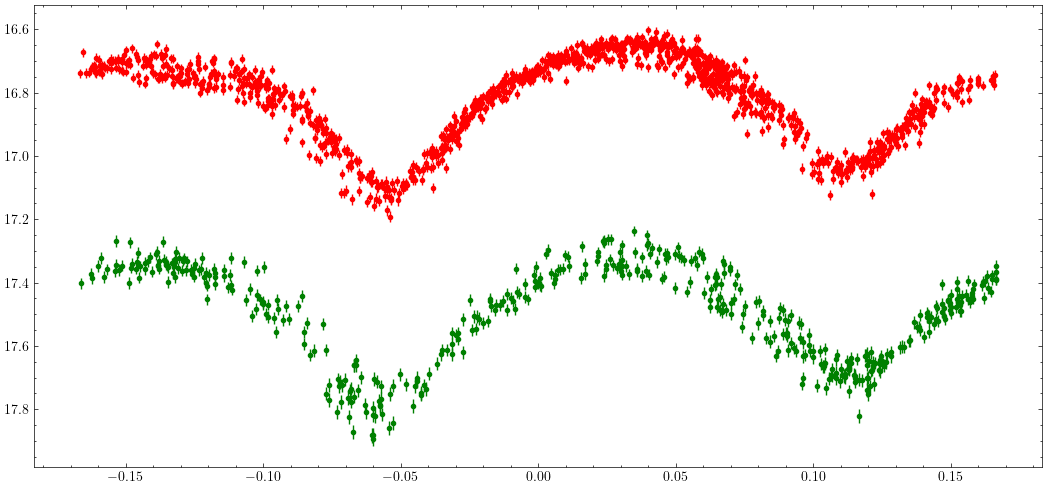

In [43]:
plt.figure(figsize=(13, 6))
for band in pd.unique(foldedTs['filter']):
    if 'ZTF' not in band:
        continue
    bandTs = cleanedZtfTs[cleanedZtfTs['filter'] == band]
    plt.errorbar(bandTs.time.value, bandTs['mag'].value, bandTs['err'].value, marker='.', ls='none', c=ztfColors[band], label=band)

plt.gca().invert_yaxis()

## Iturbide

Before applying windowed median filter, first try to discard observations based on the reported magnitude error.

In [44]:
iturbideCleanedFoldedTs = foldedTs.copy()
iturbideCleanedFoldedTs = iturbideCleanedFoldedTs[iturbideCleanedFoldedTs['filter'] == 'Iturbide:Luminance']

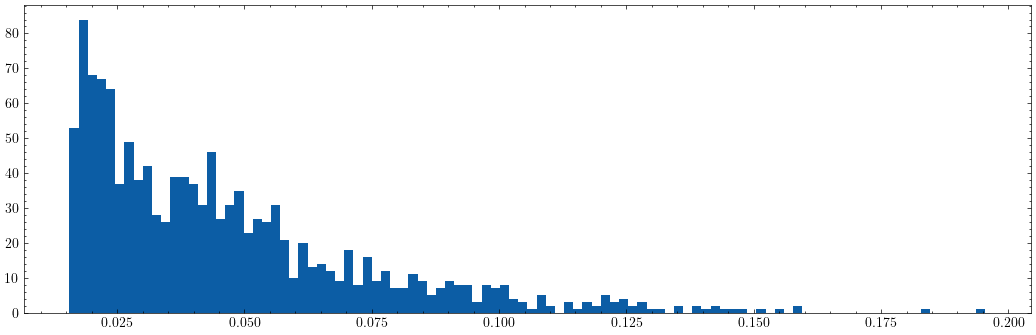

In [45]:
plt.figure(figsize=(13, 4))
plt.hist(iturbideCleanedFoldedTs['err'], bins=100)
plt.show()

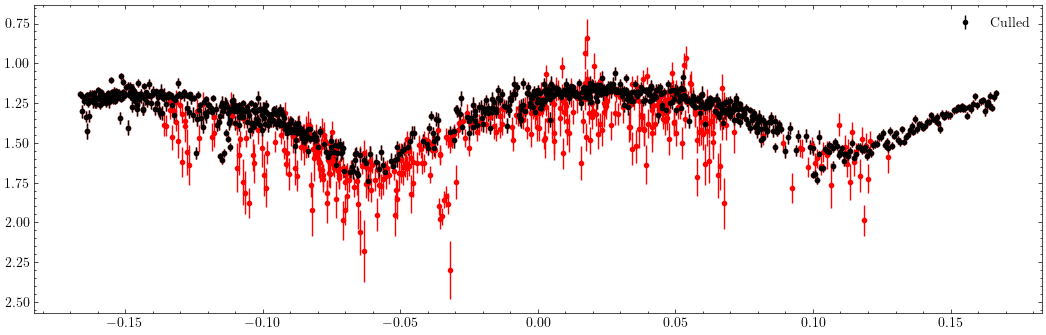

In [46]:
ERR_CUTOFF = 0.05
errMask = iturbideCleanedFoldedTs['err'].value < ERR_CUTOFF

plt.figure(figsize=(13, 4))
plt.errorbar(iturbideCleanedFoldedTs.time.value, iturbideCleanedFoldedTs['mag'], iturbideCleanedFoldedTs['err'], marker='.', ls='none', c='red')
plt.errorbar(iturbideCleanedFoldedTs[errMask].time.value, iturbideCleanedFoldedTs[errMask]['mag'], iturbideCleanedFoldedTs[errMask]['err'], marker='.', ls='none', c='black', label='Culled')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

iturbideCleanedFoldedTs = iturbideCleanedFoldedTs[errMask]

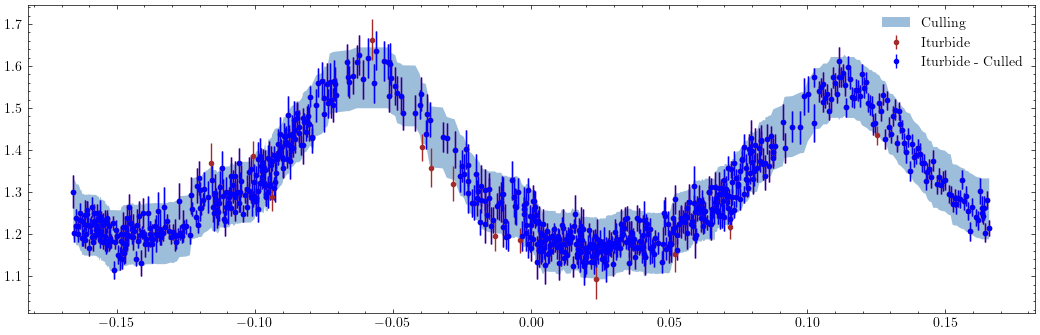

In [48]:
xi_low = 0.6
xi_high = 0.6
fltr, baseline, initSigma = median_filter_mask(iturbideCleanedFoldedTs['mag'].value, xi_low, xi_high, filter_size=round(len(iturbideCleanedFoldedTs['mag'])/30))

plt.figure(figsize=(13, 4))
plt.errorbar(iturbideCleanedFoldedTs.time.value, iturbideCleanedFoldedTs['mag'].value, iturbideCleanedFoldedTs['err'].value, marker='.', ls='none', c='brown', label='Iturbide')
plt.errorbar(iturbideCleanedFoldedTs.time.value[fltr], iturbideCleanedFoldedTs['mag'].value[fltr], iturbideCleanedFoldedTs['err'].value[fltr], marker='.', ls='none', c='blue', label="Iturbide - Culled")
plt.fill_between(iturbideCleanedFoldedTs.time.value, baseline - (xi_low*initSigma), baseline + (xi_high*initSigma), alpha=0.4, label="Culling")
plt.legend()
plt.show()

iturbideCleanedFoldedTs = iturbideCleanedFoldedTs[fltr]

# Normalized flux

In [49]:
# since phases are no longer normalized and they go from -period/2 to period/2
def findClosestQuarterPhaseIdx(foldedTs: TimeSeries) -> int:
	diff = np.abs(foldedTs.time.value - (bestPeriod.value/4))
	return np.argmin(diff)

## Iturbide

In [50]:
quarterPhaseIdx = findClosestQuarterPhaseIdx(iturbideCleanedFoldedTs)
quarterPhaseMag = iturbideCleanedFoldedTs['mag'][quarterPhaseIdx]

iturbideCleanedFoldedTs['norm_flux'] = 10**(-(2/5) * (iturbideCleanedFoldedTs['mag'].value - quarterPhaseMag.value))
iturbideCleanedFoldedTs['norm_ferr'] = (iturbideCleanedFoldedTs['norm_flux'] * iturbideCleanedFoldedTs['err'] * np.log(10)) / 2.5

iturbideCleanedFoldedTs

time,mag,err,filter,hjd,ltt_corr,obsv_date,iturbide_mag,zg_mag,zr_mag,iturbide_err,zg_err,zr_err,norm_flux,norm_ferr
,mag,mag,,,,,mag,mag,mag,mag,mag,mag,,mag
TimeDelta,float64,float64,str18,Time,TimeDelta,str10,float64,float64,float64,float64,float64,float64,float64,float64
-0.16574905335077222,1.3013000000000012,0.03956008088970497,Iturbide:Luminance,2459922.5373161673,0.0012063471745832476,2022-12-09,1.3013000000000012,———,———,0.03956008088970497,———,———,1.11768648628847,0.04072422713098342
-0.16558787687158358,1.2027999999999999,0.0206155281280883,Iturbide:Luminance,2459880.841608384,0.0033265544398984777,2022-10-28,1.2027999999999999,———,———,0.0206155281280883,———,———,1.2238269144863219,0.023237539716311435
-0.16488526109244056,1.2391000000000005,0.0206155281280883,Iturbide:Luminance,2459880.842311,0.003326530177332098,2022-10-28,1.2391000000000005,———,———,0.0206155281280883,———,———,1.1835864919618604,0.022473470544809505
-0.16461143261334926,1.2182999999999993,0.0206155281280883,Iturbide:Luminance,2459924.539855498,0.0010780078240699316,2022-12-11,1.2182999999999993,———,———,0.0206155281280883,———,———,1.2064796473587158,0.022908156693209343
-0.16418635510976762,1.2197999999999993,0.0206155281280883,Iturbide:Luminance,2459880.843009906,0.003326506041772801,2022-10-28,1.2197999999999993,———,———,0.0206155281280883,———,———,1.2048139849918464,0.02287652975728733
-0.16390758825504978,1.1997999999999998,0.01969771560359221,Iturbide:Luminance,2459924.540559342,0.0010779623057632398,2022-12-11,1.1997999999999998,———,———,0.01969771560359221,———,———,1.2272131493198564,0.02226442803910769
-0.16348755902044482,1.251100000000001,0.022472205054244233,Iturbide:Luminance,2459880.8437087024,0.0033264819089261146,2022-10-28,1.251100000000001,———,———,0.022472205054244233,———,———,1.170577035963137,0.024228212220124983
-0.16321149339951296,1.2329000000000008,0.01969771560359221,Iturbide:Luminance,2459924.5412554373,0.0010779172855032103,2022-12-11,1.2329000000000008,———,———,0.01969771560359221,———,———,1.19036459177042,0.021595911686949115


/tmp/ipykernel_175429/2936525819.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


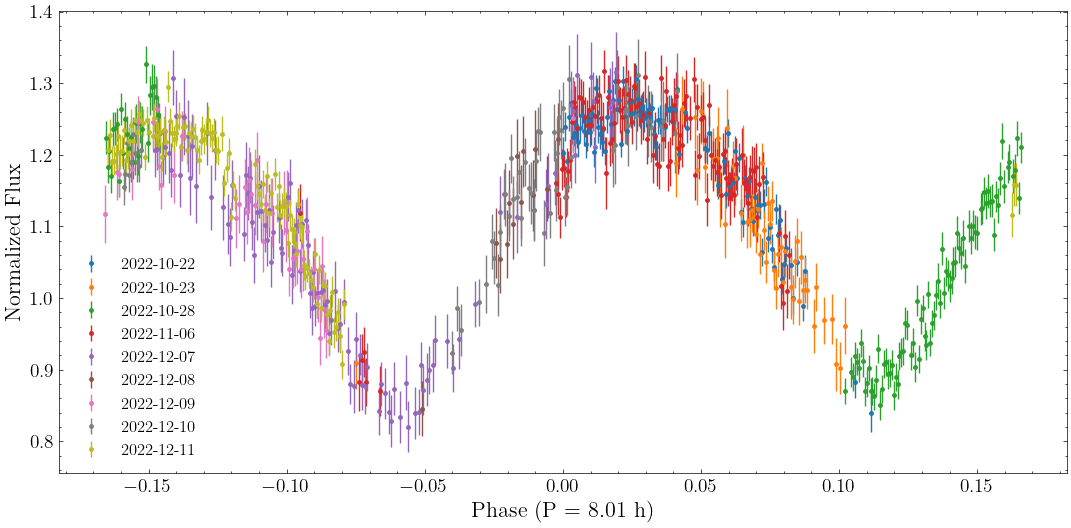

In [51]:
from matplotlib import cm

tsObsvDates = np.unique(atoDiffMag['obsv_date'])

cmap = cm.get_cmap('tab10')
dateColors = [cmap(c) for c in np.linspace(0.001, 1, len(tsObsvDates), endpoint=False)]

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 6))
for obsvDate, color in zip(tsObsvDates, dateColors):
    obsvPoints = iturbideCleanedFoldedTs[iturbideCleanedFoldedTs['obsv_date'] == obsvDate]
    ax.errorbar(obsvPoints.time.value, obsvPoints['norm_flux'].value, obsvPoints['norm_ferr'].value, fmt='.', color=color, markersize=5, label=obsvDate)
ax.legend(fontsize=12)

ax.set_xlabel(f"Phase (P = {period.value * 24:.2f} h)", fontsize=16)
ax.set_ylabel("Normalized Flux", fontsize=16)

ax.tick_params(labelsize=14)

## ZTF

In [52]:
fluxBandData = []

for band in ['ZTF:g', 'ZTF:r']:
    bandData = cleanedZtfTs[cleanedZtfTs['filter'] == band].copy()
    quarterPhaseIdx = findClosestQuarterPhaseIdx(bandData)
    quarterPhaseMag = bandData['mag'][quarterPhaseIdx]

    bandData['norm_flux'] = 10**(-(2/5) * (bandData['mag'].value - quarterPhaseMag.value))
    bandData['norm_ferr'] = (bandData['norm_flux'] * bandData['err'] * np.log(10)) / 2.5

    fluxBandData.append(bandData)
cleanedZtfFluxTs = vstack(fluxBandData)
cleanedZtfFluxTs

time,mag,err,filter,hjd,ltt_corr,obsv_date,iturbide_mag,zg_mag,zr_mag,iturbide_err,zg_err,zr_err,norm_flux,norm_ferr
,mag,mag,,,,,mag,mag,mag,mag,mag,mag,,mag
TimeDelta,float64,float64,str18,Time,TimeDelta,str10,float64,float64,float64,float64,float64,float64,float64,float64
-0.16627046349418356,17.4029655,0.0183366165,ZTF:g,2459855.823404422,--,--,———,17.4029655,———,———,0.0183366165,———,1.1723649879800246,0.019799659519879206
-0.16253382654845708,17.3737259,0.0181318633,ZTF:g,2459171.6813231735,--,--,———,17.3737259,———,———,0.0181318633,———,1.2043665362981346,0.020112997340930524
-0.16226560021142128,17.3862724,0.0182190519,ZTF:g,2459853.8260075753,--,--,———,17.3862724,———,———,0.0182190519,———,1.19052927738052,0.019977518109840654
-0.1602459959271612,17.347332,0.0179516952,ZTF:g,2459059.938682193,--,--,———,17.347332,———,———,0.0179516952,———,1.234003069565328,0.020403157676441377
-0.15912860067079526,17.3224964,0.0177861098,ZTF:g,2459402.84662591,--,--,———,17.3224964,———,———,0.0177861098,———,1.2625555054407362,0.020682695068979455
-0.1580097130731734,17.3823967,0.0181920044,ZTF:g,2459153.6732318965,--,--,———,17.3823967,———,———,0.0181920044,———,1.19478664628289,0.02001919419375135
-0.15697123541775504,17.358345,0.018026337,ZTF:g,2459068.9482646487,--,--,———,17.358345,———,———,0.018026337,———,1.2215494148336392,0.020281226063424317
-0.15408011853038087,17.3641415,0.0180659331,ZTF:g,2459843.8271845067,--,--,———,17.3641415,———,———,0.0180659331,———,1.2150452164971004,0.020217549620721784


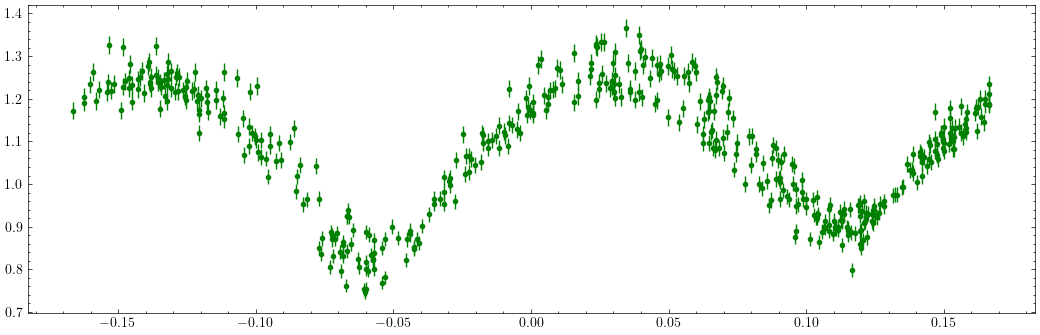

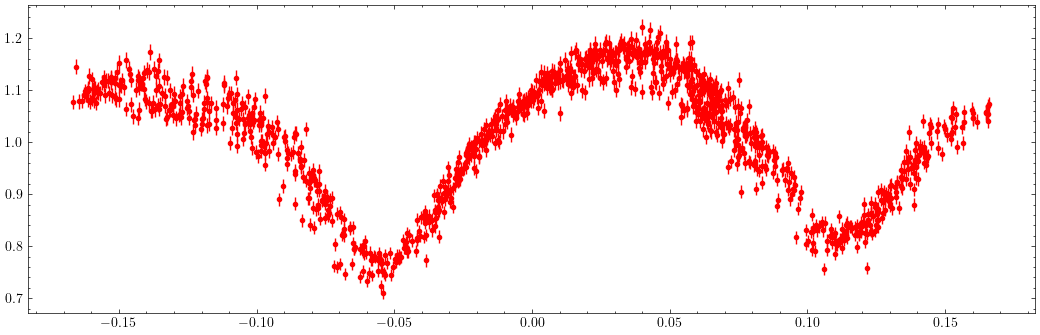

In [53]:
for band in ['ZTF:g', 'ZTF:r']:
    bandData = cleanedZtfFluxTs[cleanedZtfFluxTs['filter'] == band]

    plt.figure(figsize=(13, 4))
    plt.errorbar(bandData.time.value, bandData['norm_flux'].value, bandData['norm_ferr'].value, ls='none', marker='.', c=ztfColors[band])
    plt.show()

In [61]:
ztf_minFlux_idx = np.argmin(cleanedZtfFluxTs['norm_flux'])
iturbide_minFlux_idx = np.argmin(iturbideCleanedFoldedTs['norm_flux'])

iturbide_minPhase = iturbideCleanedFoldedTs.time.value[iturbide_minFlux_idx]
ztf_minPhase = cleanedZtfFluxTs.time.value[ztf_minFlux_idx]
iturbide_minPhase, ztf_minPhase

(-0.05615445955645574, -0.05403145499149107)

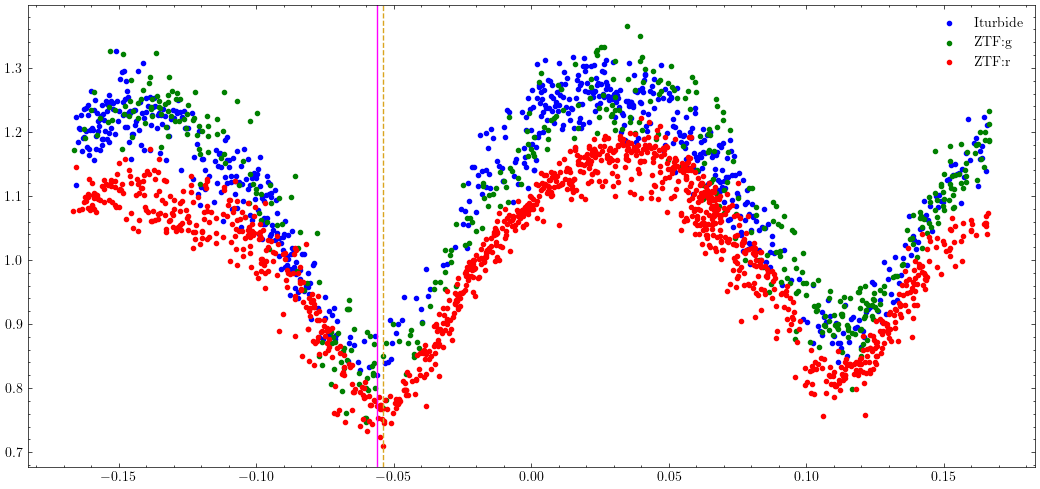

In [68]:
plt.figure(figsize=(13, 6))
plt.scatter(iturbideCleanedFoldedTs.time.value, iturbideCleanedFoldedTs['norm_flux'], marker='.', label='Iturbide', c='b')
for band in ['ZTF:g', 'ZTF:r']:
    bandData = cleanedZtfFluxTs[cleanedZtfFluxTs['filter'] == band]
    plt.scatter(bandData.time.value, bandData['norm_flux'].value, marker='.', c=ztfColors[band], label=band)
plt.axvline(iturbide_minPhase, c='magenta')
plt.axvline(ztf_minPhase, c='goldenrod', ls='--')
plt.legend()
plt.show()

# Write cleaned time series

For use in PHOEBE.

In [54]:
iturbideCleanedFoldedTs.remove_columns(['iturbide_mag', 'iturbide_err', 'zg_mag', 'zr_mag', 'zg_err', 'zr_err'])
iturbideCleanedFoldedTs

time,mag,err,filter,hjd,ltt_corr,obsv_date,norm_flux,norm_ferr
,mag,mag,,,,,,mag
TimeDelta,float64,float64,str18,Time,TimeDelta,str10,float64,float64
-0.16574905335077222,1.3013000000000012,0.03956008088970497,Iturbide:Luminance,2459922.5373161673,0.0012063471745832476,2022-12-09,1.11768648628847,0.04072422713098342
-0.16558787687158358,1.2027999999999999,0.0206155281280883,Iturbide:Luminance,2459880.841608384,0.0033265544398984777,2022-10-28,1.2238269144863219,0.023237539716311435
-0.16488526109244056,1.2391000000000005,0.0206155281280883,Iturbide:Luminance,2459880.842311,0.003326530177332098,2022-10-28,1.1835864919618604,0.022473470544809505
-0.16461143261334926,1.2182999999999993,0.0206155281280883,Iturbide:Luminance,2459924.539855498,0.0010780078240699316,2022-12-11,1.2064796473587158,0.022908156693209343
-0.16418635510976762,1.2197999999999993,0.0206155281280883,Iturbide:Luminance,2459880.843009906,0.003326506041772801,2022-10-28,1.2048139849918464,0.02287652975728733
-0.16390758825504978,1.1997999999999998,0.01969771560359221,Iturbide:Luminance,2459924.540559342,0.0010779623057632398,2022-12-11,1.2272131493198564,0.02226442803910769
-0.16348755902044482,1.251100000000001,0.022472205054244233,Iturbide:Luminance,2459880.8437087024,0.0033264819089261146,2022-10-28,1.170577035963137,0.024228212220124983
-0.16321149339951296,1.2329000000000008,0.01969771560359221,Iturbide:Luminance,2459924.5412554373,0.0010779172855032103,2022-12-11,1.19036459177042,0.021595911686949115


In [56]:
iturbideCleanedFoldedTs.write(ITURBIDE_OUTPUT_PATH, overwrite=True)

In [57]:
cleanedZtfFluxTs.remove_columns(['obsv_date', 'iturbide_mag', 'iturbide_err', 'zg_mag', 'zr_mag', 'zg_err', 'zr_err'])
cleanedZtfFluxTs

time,mag,err,filter,hjd,ltt_corr,norm_flux,norm_ferr
,mag,mag,,,,,mag
TimeDelta,float64,float64,str18,Time,TimeDelta,float64,float64
-0.16627046349418356,17.4029655,0.0183366165,ZTF:g,2459855.823404422,--,1.1723649879800246,0.019799659519879206
-0.16253382654845708,17.3737259,0.0181318633,ZTF:g,2459171.6813231735,--,1.2043665362981346,0.020112997340930524
-0.16226560021142128,17.3862724,0.0182190519,ZTF:g,2459853.8260075753,--,1.19052927738052,0.019977518109840654
-0.1602459959271612,17.347332,0.0179516952,ZTF:g,2459059.938682193,--,1.234003069565328,0.020403157676441377
-0.15912860067079526,17.3224964,0.0177861098,ZTF:g,2459402.84662591,--,1.2625555054407362,0.020682695068979455
-0.1580097130731734,17.3823967,0.0181920044,ZTF:g,2459153.6732318965,--,1.19478664628289,0.02001919419375135
-0.15697123541775504,17.358345,0.018026337,ZTF:g,2459068.9482646487,--,1.2215494148336392,0.020281226063424317
-0.15408011853038087,17.3641415,0.0180659331,ZTF:g,2459843.8271845067,--,1.2150452164971004,0.020217549620721784


In [58]:
cleanedZtfFluxTs.write(CLEANED_ZTF_OUTPUT_PATH, overwrite=True)

In [59]:
period.value

0.3335669516750462